In [1]:
import time
import copy
import random
from params import *
import torch_geometric
import utils.model_utils as m_util
from model_src.demo_functions import *
from utils.misc_utils import RunningStatMeter
from model_src.model_helpers import BookKeeper
from model_src.comp_graph.tf_comp_graph import OP2I
from model_src.comp_graph.tf_comp_graph_models import make_cg_regressor, make_embedding_model, make_embedding_regressor_model, make_embedding_regressor_modelV2
from model_src.predictor.gpi_family_data_manager import FamilyDataManager
from model_src.comp_graph.tf_comp_graph_dataloaders import CGRegressDataLoader
from utils.model_utils import set_random_seed, device, add_weight_decay, get_activ_by_name
from model_src.predictor.model_perf_predictor import train_predictor, run_predictor_demo, train_embedding_model, train_predictorV2, run_predictor_demoV2
import pickle
import psutil

/opt/conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-15 15:40:16.802335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 15:40:16.947796: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 15:40:17.620124: W tensorflow/compiler/xla/stream_executor/platform/default/dso

In [2]:
import imp
import model_src
imp.reload(model_src.comp_graph.tf_comp_graph_dataloaders)
from model_src.comp_graph.tf_comp_graph_dataloaders import CGRegressDataLoader


/tmp/ipykernel_28789/1867810216.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
def gnn_constructor(in_channels, out_channels):
    nn = torch.nn.Sequential(torch.nn.Linear(in_channels, in_channels),
                                torch.nn.Linear(in_channels, out_channels),
                                )
    return torch_geometric.nn.GINConv(nn=nn)


In [4]:
model = make_embedding_regressor_modelV2(n_unique_labels=len(OP2I().build_from_file("/home/ec2-user/nas-rec-engine/data/alternative_primitives.txt")), out_embed_size=256,
                              shape_embed_size=8, kernel_embed_size=8, n_unique_kernels=8, n_shape_vals=6,
                              hidden_size=256, out_channels=256,
                              gnn_constructor=gnn_constructor,
                              gnn_activ=get_activ_by_name("relu"), n_gnn_layers=6,
                              dropout_prob=0.2, aggr_method="mean",
                              regressor_activ=get_activ_by_name(None)).to(device())

In [5]:
name = "CL_dropout_encoder2x256_decoder_attn_regression_model109_gmm2x256_transform"
params_model_name = "gpi_acc_predictor_{}_seed{}".format(name, 109)
book_keeper = BookKeeper(log_file_name=params_model_name + ".txt",
                            model_name=params_model_name,
                            saved_models_dir="saved_models",
                            init_eval_perf=float("inf"), eval_perf_comp_func=lambda old, new: new < old,
                            saved_model_file="",
                            logs_dir="logs")

checkpoint = "/home/ec2-user/nas-rec-engine/gpi_acc_predictor_CL_dropout_encoder2x256_decoder_attn_regression_model109_gmm2x256_transformed_flops_giant_unlocked_seed109_best.pt"
book_keeper.load_model_checkpoint(model, allow_silent_fail=False, skip_eval_perfs=True,
                                        checkpoint_file=checkpoint)
book_keeper.log("Loaded checkpoint: {}".format(checkpoint))

Model name: gpi_acc_predictor_CL_dropout_encoder2x256_decoder_attn_regression_model109_gmm2x256_transform_seed109
Saved models dir: saved_models
Log dir: logs
Found checkpoint: /home/ec2-user/nas-rec-engine/gpi_acc_predictor_CL_dropout_encoder2x256_decoder_attn_regression_model109_gmm2x256_transformed_flops_giant_unlocked_seed109_best.pt, loading
Found best_eval_perf: 6.187521872901748, best_eval_iter: 3
Completed iterations: 3
Loaded checkpoint: /home/ec2-user/nas-rec-engine/gpi_acc_predictor_CL_dropout_encoder2x256_decoder_attn_regression_model109_gmm2x256_transformed_flops_giant_unlocked_seed109_best.pt


In [6]:
def _batch_fwd_func(_model, _batch):
        # Define how a batch is handled by the model
        regular_node_inds = _batch[DK_BATCH_CG_REGULAR_IDX]
        regular_node_shapes = _batch[DK_BATCH_CG_REGULAR_SHAPES]
        weighted_node_inds = _batch[DK_BATCH_CG_WEIGHTED_IDX]
        weighted_node_shapes = _batch[DK_BATCH_CG_WEIGHTED_SHAPES]
        weighted_node_kernels = _batch[DK_BATCH_CG_WEIGHTED_KERNELS]
        weighted_node_bias = _batch[DK_BATCH_CG_WEIGHTED_BIAS]
        edge_tsr_list = _batch[DK_BATCH_EDGE_TSR_LIST]
        batch_last_node_idx_list = _batch[DK_BATCH_LAST_NODE_IDX_LIST]
        return _model(regular_node_inds, regular_node_shapes,
                      weighted_node_inds, weighted_node_shapes, weighted_node_kernels, weighted_node_bias,
                      edge_tsr_list, batch_last_node_idx_list)

In [7]:
INPUT = 'input'
OUTPUT = 'output'
CONV1X1 = 'conv1x1-bn-relu'
CONV3X3 = 'conv3x3-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'

In [10]:
# Create an Inception-like module (5x5 convolution replaced with two 3x3
# convolutions).
matrix = [[0, 1, 1, 1, 0, 1, 0],    # input layer
            [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
            [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
            [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
            [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
            [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
            [0, 0, 0, 0, 0, 0, 0]]
ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT]

In [7]:
from nasbench.lib.model_builder import build_module
from nasbench import api
import nasbench1
import nasbench1_spec

In [16]:
spec = nasbench1_spec._ToModelSpec(matrix, ops)
net = nasbench1.Network(spec, stem_out=128, num_stacks=3, num_mods=3, num_classes=10)

In [8]:
from nasbench import api
from model_src.comp_graph.tf_comp_graph import ComputeGraph, RegularNode, WeightedNode, OP2I
from torchview.computation_node import TensorNode, ModuleNode, FunctionNode
from tqdm import tqdm
from torchview import draw_graph
from torchview.computation_graph import ComputationGraph
from nasbench import api
import nasbench1
import nasbench1_spec
import pickle

In [10]:
def process_graph(model_graph: ComputationGraph, op2i, i):
    regular_nodes, weighted_nodes = [], []
    seen_nodes = {}
    MAX_H, MAX_W, MAX_C, MAX_K = 0, 0, 0, 0


    for edge in model_graph.edge_list:
        input_node, output_node = edge
        for node in [input_node, output_node]:
            if type(node) == TensorNode:
                #print(node.name, node.tensor_shape, node.main_node, node.tensor_id, node.node_id, model_graph.id_dict[node.node_id])
                node_id = node.node_id
                idx_id = model_graph.id_dict[node.node_id]
                if idx_id in seen_nodes:
                    continue
                str_id = f"{idx_id}|_{node.main_node.name}"
                #print("found input? ", node.main_node.name.split("-")[0])
                op_type_idx = op2i[node.main_node.name.split("-")[0]]
                # [Hin, Hout, Win, Wout, Cin, Cout] for every node
                rg_node = RegularNode(str_id=str_id, label=node.main_node.name, op_type_idx=op_type_idx)
                if len(node.tensor_shape) == 4:
                    rg_node.resolution = [node.tensor_shape[2], node.tensor_shape[2], node.tensor_shape[3], node.tensor_shape[3], node.tensor_shape[1], node.tensor_shape[1]]
                    MAX_H = max(node.tensor_shape[2], node.tensor_shape[2], MAX_H)
                    MAX_W = max(node.tensor_shape[3], node.tensor_shape[3], MAX_W)
                    MAX_C = max(node.tensor_shape[1], node.tensor_shape[1], MAX_C)          
                else:
                    rg_node.resolution = (0, 0, 0, 0, node.tensor_shape[1], node.tensor_shape[1])
                    MAX_C = max(node.tensor_shape[1], node.tensor_shape[1], MAX_C)
                seen_nodes[idx_id] = (rg_node, len(regular_nodes))
                #print(rg_node)
                rg_node.metadata = {"torch_id":node_id}
                regular_nodes.append(rg_node)
                
            elif type(node) == ModuleNode:
                #print(node.name, node.node_id, node.input_shape, node.output_shape, node.compute_unit_id, node.is_activation, model_graph.id_dict[node.node_id], node.output_nodes)
                if node.name in ["Sequential", "Conv2d", "ConvBnRelu", "Linear"]:
                    node_id = node.node_id
                    idx_id = model_graph.id_dict[node.node_id]
                    if idx_id in seen_nodes:
                        continue
                    str_id = f"{idx_id}|_{node.name}"
                    op_type_idx = op2i[node.name]
                    if "Conv" not in node.name:
                        shape = [node.input_shape[0][1], node.output_shape[0][1], 0, 0]
                    else:
                        shape = [node.input_shape[0][1], node.output_shape[0][1], 1, 1]
                        MAX_K = max(1, MAX_K)
                        if node.input_shape[0][1] != node.output_shape[0][1]:
                            #val = kernel_size = node.output_shape[0][1] / (node.input_shape[0][2]) - 1
                            shape = [node.input_shape[0][1], node.output_shape[0][1], 3, 3]
                            MAX_K = max(MAX_K, 3)
                            
                    # [Hin, Hout, Win, Wout, Cin, Cout] for every node
                    w_node = WeightedNode(str_id=str_id, label=node.name, op_type_idx=op_type_idx, shape=shape)
                    if len(node.input_shape[0]) == 4:
                        w_node.resolution = (node.input_shape[0][2], node.output_shape[0][2], node.input_shape[0][3], node.output_shape[0][3], node.input_shape[0][1], node.output_shape[0][1])
                        MAX_H = max(node.input_shape[0][2], node.output_shape[0][2], MAX_H)
                        MAX_W = max(node.input_shape[0][3], node.output_shape[0][3], MAX_W)
                        MAX_C = max(node.input_shape[0][1], node.output_shape[0][1], MAX_C)
                    else:
                        w_node.resolution = (0, 0, 0, 0, node.input_shape[0][1], node.output_shape[0][1])
                        MAX_C = max(node.input_shape[0][1], node.output_shape[0][1], MAX_C)
                    w_node.strides = 1
                    seen_nodes[idx_id] = (w_node, len(weighted_nodes))
                    #print(w_node)
                    w_node.metadata = {"torch_id":node_id}
                    weighted_nodes.append(w_node)
                else:
                    node_id = node.node_id
                    idx_id = model_graph.id_dict[node.node_id]
                    if idx_id in seen_nodes:
                        continue
                    str_id = f"{idx_id}|_{node.name}"
                    op_type_idx = op2i[node.name]
                    # [Hin, Hout, Win, Wout, Cin, Cout] for every node
                    rg_node = RegularNode(str_id=str_id, label=node.name, op_type_idx=op_type_idx)
                    if len(node.input_shape[0]) == 4:
                        rg_node.resolution = (node.input_shape[0][2], node.output_shape[0][2], node.input_shape[0][3], node.output_shape[0][3], node.input_shape[0][1], node.output_shape[0][1])
                        MAX_H = max(node.input_shape[0][2], node.output_shape[0][2], MAX_H)
                        MAX_W = max(node.input_shape[0][3], node.output_shape[0][3], MAX_W)
                        MAX_C = max(node.input_shape[0][1], node.output_shape[0][1], MAX_C)
                    else:
                        rg_node.resolution = (0, 0, 0, 0, node.input_shape[0][1], node.output_shape[0][1])
                        MAX_C = max(node.input_shape[0][1], node.output_shape[0][1], MAX_C)
                    seen_nodes[idx_id] = (rg_node, len(regular_nodes))
                    #print(rg_node)
                    rg_node.metadata = {"torch_id":node_id}
                    regular_nodes.append(rg_node)
                
            elif type(node) == FunctionNode:
                #print(node.name, node.node_id, node.input_shape, node.output_shape, node.compute_unit_id, model_graph.id_dict[node.node_id], node.output_nodes)
                node_id = node.node_id
                idx_id = model_graph.id_dict[node.node_id]
                if idx_id in seen_nodes:
                    continue
                str_id = f"{idx_id}|_{node.name}"
                op_type_idx = op2i[node.name]
                # [Hin, Hout, Win, Wout, Cin, Cout] for every node
                #print(node.input_shape, node.output_shape, node.name)
                rg_node = RegularNode(str_id=str_id, label=node.name, op_type_idx=op_type_idx)
                if len(node.input_shape) == 4 and len(node.output_shape) == 4:
                    rg_node.resolution = (node.input_shape[0][2], node.output_shape[0][2], node.input_shape[0][3], node.output_shape[0][3], node.input_shape[0][1], node.output_shape[0][1])
                    MAX_H = max(node.input_shape[0][2], node.output_shape[0][2], MAX_H)
                    MAX_W = max(node.input_shape[0][3], node.output_shape[0][3], MAX_W)
                    MAX_C = max(node.input_shape[0][1], node.output_shape[0][1], MAX_C)
                
                elif len(node.input_shape) == 4 and len(node.output_shape) == 2:
                    rg_node.resolution = (node.input_shape[0][2], 0, node.input_shape[0][3], 0, node.input_shape[0][1], node.output_shape[0][1])
                    MAX_H = max(node.input_shape[0][2], 0, MAX_H)
                    MAX_W = max(node.input_shape[0][3], 0, MAX_W)
                    MAX_C = max(node.input_shape[0][1], node.output_shape[0][1], MAX_C)
                    
                else:
                    rg_node.resolution = (0, 0, 0, 0, node.input_shape[0][1], node.output_shape[0][1])
                    MAX_C = max(node.input_shape[0][1], node.output_shape[0][1], MAX_C)
                    
                seen_nodes[idx_id] = (rg_node, len(regular_nodes))
                #print(rg_node)
                rg_node.metadata = {"torch_id":node_id}
                regular_nodes.append(rg_node)
    
    cg_node_ls = weighted_nodes + regular_nodes
    new_edge_list = []
    for edge in model_graph.edge_list:
        in_node, out_node = edge
        cg_in_node, cg_in_pos = seen_nodes[model_graph.id_dict[in_node.node_id]]
        if isinstance(cg_in_node, RegularNode):
            cg_in_pos += len(weighted_nodes) 
        cg_out_node, cg_out_pos = seen_nodes[model_graph.id_dict[out_node.node_id]]
        if isinstance(cg_out_node, RegularNode):
            cg_out_pos += len(weighted_nodes) 
        new_edge_list.append((cg_in_pos, cg_out_pos))
        
    new_cg = ComputeGraph(C_in=3, H=32, W=32, name=f"test{i}", 
                      max_hidden_size=MAX_C, max_derived_H=MAX_H, 
                      max_derived_W=MAX_W, max_kernel_size=MAX_K)

    new_cg.edge_pairs = new_edge_list
    new_cg.regular_nodes = regular_nodes
    new_cg.weighted_nodes = weighted_nodes
    new_cg.n_regular_nodes = len(regular_nodes)
    new_cg.n_weighted_nodes = len(weighted_nodes)
    
    return new_cg

In [39]:
# create dot graph
op2i = OP2I().build_from_file("/home/ec2-user/nas-rec-engine/data/alternative_primitives.txt")
model_graph = draw_graph(
    net, input_size=(1,3,32,32),
    graph_name=f'MLP{0}'
)

new_cg = process_graph(model_graph, op2i, 0)

In [51]:
new_cg

ComputeGraph[test0](n_nodes: 144, n_edges: 170)

In [42]:
new_cg.weighted_nodes[0].metadata

{'torch_id': '140367050382448'}

In [37]:
id(net.layers[2])

140367103987328

In [11]:
def get_layer_metric_array(net, metric, mode): 
    metric_array = []
    id_array = []

    for layer in net.modules():
        if mode=='channel' and hasattr(layer,'dont_ch_prune'):
            continue
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            metric_array.append(metric(layer))
            id_array.append(id(layer))
    
    return metric_array, id_array

In [55]:
available_measures = []
_measure_impls = {}


def measure(name, bn=True, copy_net=True, force_clean=True, **impl_args):
    def make_impl(func):
        def measure_impl(net_orig, device, *args, **kwargs):
            if copy_net:
                net = net_orig.get_prunable_copy(bn=bn).to(device)
            else:
                net = net_orig
            ret = func(net, *args, **kwargs, **impl_args)
            if copy_net and force_clean:
                import gc
                import torch
                del net
                torch.cuda.empty_cache()
                gc.collect()
            return ret

        global _measure_impls
        if name in _measure_impls:
            raise KeyError(f'Duplicated measure! {name}')
        available_measures.append(name)
        _measure_impls[name] = measure_impl
        return func
    return make_impl


def calc_measure(name, net, device, *args, **kwargs):
    return _measure_impls[name](net, device, *args, **kwargs)


def load_all():
    from . import grad_norm
    from . import snip
    from . import grasp
    from . import fisher
    from . import jacob_cov
    from . import plain
    from . import synflow


In [56]:
def sum_arr(arr):
    sum = 0.
    for i in range(len(arr)):
        sum += torch.sum(arr[i])
    return sum.item()

In [47]:
import torch.nn as nn

In [60]:
inputs = torch.ones((1,3,32,32)).cuda()
device = inputs.device

#convert params to their abs. Keep sign for converting it back.
@torch.no_grad()
def linearize(net):
    signs = {}
    for name, param in net.state_dict().items():
        signs[name] = torch.sign(param)
        param.abs_()
    return signs

#convert to orig values
@torch.no_grad()
def nonlinearize(net, signs):
    for name, param in net.state_dict().items():
        if 'weight_mask' not in name:
            param.mul_(signs[name])

# keep signs of all params
signs = linearize(net)

# Compute gradients with input of 1s 
net.zero_grad()
net.double()
input_dim = list(inputs[0,:].shape)
inputs = torch.ones([1] + input_dim).double().to(device)
output = net.forward(inputs)
torch.sum(output).backward() 

# select the gradients that we want to use for search/prune
def synflow(layer):
    if layer.weight.grad is not None:
        return torch.abs(layer.weight * layer.weight.grad)
    else:
        return torch.zeros_like(layer.weight)

grads_abs, id_array = get_layer_metric_array(net, synflow, "non")

# apply signs of all params
nonlinearize(net, signs)



In [53]:
len(grads_abs), len(new_cg.weighted_nodes)

(74, 74)

In [57]:
sum_arr(grads_abs)

30.03041010978871

In [61]:
import copy

In [62]:
new_cg_copy = copy.deepcopy(new_cg)

In [70]:
original_val = 0
loader = CGRegressDataLoader(1, [(new_cg, 0)])
with torch.no_grad():
        model.eval()
        for batch in tqdm(loader, desc="Dev", ascii=True):
                batch = _batch_fwd_func(model, batch)
                original_val = batch.squeeze(0)[0]

Dev: 100%|##########| 1/1 [00:00<00:00, 47.35it/s]


In [71]:
new_cg

ComputeGraph[test0](n_nodes: 144, n_edges: 170)

In [147]:
n = len(new_cg.weighted_nodes)
batch_vals = []
node_id2idx = {n.str_id: i for i, n in enumerate(new_cg.nodes)}
N = len(new_cg.weighted_nodes)
for i in range(3):
        new_cg_copy = copy.deepcopy(new_cg)
        if i == 0:
                nodes = new_cg_copy.weighted_nodes[0:int(N/3)]
        elif i == 1:
                nodes = new_cg_copy.weighted_nodes[int(N/3):int(2*N/3)]
        else:
                nodes = new_cg_copy.weighted_nodes[int(2*N/3):]
        new_cg_copy.n_weighted_nodes -= 1
        #new_cg_copy.weighted_nodes.pop(i)
        
        edge_pairs = []
        ban_list = [node_id2idx[node.str_id] for node in nodes]
        for src, dst in new_cg_copy.edge_pairs:
                if src not in ban_list and dst not in ban_list:
                    edge_pairs.append((src, dst))
                else:
                    pass
        
        new_cg_copy.edge_pairs = edge_pairs
        print(new_cg_copy)

        loader = CGRegressDataLoader(1, [(new_cg_copy, 0)])
        with torch.no_grad():
                model.eval()
                for batch in tqdm(loader, desc="Dev", ascii=True):
                        batch = _batch_fwd_func(model, batch)
                        batch_vals.append(batch)
        del new_cg_copy


ComputeGraph[test0](n_nodes: 144, n_edges: 122)


Dev: 100%|##########| 1/1 [00:00<00:00, 20.44it/s]


ComputeGraph[test0](n_nodes: 144, n_edges: 120)


Dev: 100%|##########| 1/1 [00:00<00:00, 47.78it/s]


ComputeGraph[test0](n_nodes: 144, n_edges: 120)


Dev: 100%|##########| 1/1 [00:00<00:00, 62.61it/s]


In [148]:
original_val - torch.cat(batch_vals)[:,0]

tensor([0.0012, 0.0015, 0.0012], device='cuda:0')

In [82]:
import torch.nn.functional as F


In [153]:
pre_vals = (original_val - torch.cat(batch_vals)[:,0])
post_vals = pre_vals / torch.sum(pre_vals); post_vals

tensor([0.3074, 0.3808, 0.3118], device='cuda:0')

In [92]:
new_cg_dictionary = {k: v for k, v in zip(node_id_vals, list(vals))}


In [ ]:
sum = 0.
segment_length = len(grads_abs) // 3
for i in range(len(grads_abs)):
    j = min((i // segment_length), 2)
    print(j)
    layer_val = post_vals[j]
    sum += layer_val * torch.sum(grads_abs[i])
sum.item()

In [109]:
net.layers[3].children()

<generator object Module.children at 0x7fa9c60944a0>

In [121]:

# Iterate over named modules and find the parent module
parent_id = None
for module in net.modules():
    ls = [id(mod) for mod in module.children()]
    #print(ls)
    if 140367103984160 in ls:
        print("found")
        # Found the child module, get the ID of the parent module
        parent_id = id(module)

found


In [137]:
parent_id = None
for module in net.modules():
    if id(module) == 140367050382448:
        #print([id(child) for child in module.layers()])
        print(module._get_name())

In [133]:
str_id_array = [str(ids) for ids in id_array]

In [134]:

common_values = set(node_id_vals) & set(str_id_array)
num_common_values = len(common_values)

print(num_common_values)

0


In [146]:
model_graph.edge_list[6][0].node_id

'140367049932080'

In [18]:
dataset_path = '/home/ec2-user/nasbench_full.tfrecord'
# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench(dataset_path)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 152 seconds


In [161]:
def get_relative_weights(new_cg, model):
    n = len(new_cg.weighted_nodes)

    batch_vals = []
    node_id2idx = {n.str_id: i for i, n in enumerate(new_cg.nodes)}
    N = len(new_cg.weighted_nodes)
    for i in range(3):
        new_cg_copy = copy.deepcopy(new_cg)
        if i == 0:
                nodes = new_cg_copy.weighted_nodes[0:int(N/3)]
        elif i == 1:
                nodes = new_cg_copy.weighted_nodes[int(N/3):int(2*N/3)]
        else:
                nodes = new_cg_copy.weighted_nodes[int(2*N/3):]
        new_cg_copy.n_weighted_nodes -= 1
        #new_cg_copy.weighted_nodes.pop(i)
        
        edge_pairs = []
        ban_list = [node_id2idx[node.str_id] for node in nodes]
        for src, dst in new_cg_copy.edge_pairs:
                if src not in ban_list and dst not in ban_list:
                    edge_pairs.append((src, dst))
                else:
                    pass
        
        new_cg_copy.edge_pairs = edge_pairs

        loader = CGRegressDataLoader(1, [(new_cg_copy, 0)])
        with torch.no_grad():
                model.eval()
                for batch in tqdm(loader, desc="Dev", ascii=True):
                        batch = _batch_fwd_func(model, batch)
                        batch_vals.append(batch)
        del new_cg_copy
    return batch_vals

In [ ]:
op2i = OP2I().build_from_file("/home/ec2-user/nas-rec-engine/data/alternative_primitives.txt")
results = []
torch.autograd.set_detect_anomaly(True)
z = 0
for hash in tqdm(nasbench.hash_iterator()):
    if z < 10000:
        z += 1
        print(i)
    else:
        try:
            info = nasbench.get_metrics_from_hash(hash)
            matrix = info[0]['module_adjacency']
            ops = info[0]['module_operations']
            acc = info[1][108][-1]['final_test_accuracy']
            params = info[0]['trainable_parameters']
            
            # create pytorch network
            spec = nasbench1_spec._ToModelSpec(matrix, ops)
            net = nasbench1.Network(spec, stem_out=128, num_stacks=3, num_mods=3, num_classes=10).to("cuda:0")
            
            # create dot graph
            model_graph = draw_graph(
                net, input_size=(1,3,32,32),
                graph_name=f'MLP{i}'
            )
            
            z += 1
            
            new_cg = process_graph(model_graph, op2i, i)
            batch_vals = get_relative_weights(new_cg, model)
            original_val = 0
            loader = CGRegressDataLoader(1, [(new_cg, 0)])
            with torch.no_grad():
                    model.eval()
                    for batch in tqdm(loader, desc="Dev", ascii=True):
                            batch = _batch_fwd_func(model, batch)
                            original_val = batch.squeeze(0)[0]
            pre_vals = (original_val - torch.cat(batch_vals)[:,0])
            post_vals = pre_vals / torch.sum(pre_vals); post_vals
            
            # keep signs of all params
            signs = linearize(net)

            # Compute gradients with input of 1s 
            net.zero_grad()
            net.double()
            input_dim = [3,32,32]
            inputs = torch.ones([1] + input_dim).double()
            output = net.forward(inputs.to("cuda:0"))
            torch.sum(output).backward() 
            
            grads_abs, id_array = get_layer_metric_array(net, synflow, "non")

            # apply signs of all params
            nonlinearize(net, signs)
            
            sum = 0.
            segment_length = len(grads_abs) // 3
            for i in range(len(grads_abs)):
                j = min((i // segment_length), 2)
                layer_val = post_vals[j]
                sum += layer_val * torch.sum(grads_abs[i])
            final_score = sum.item()
            
            sum = 0.
            for i in range(len(grads_abs)):
                sum += torch.sum(grads_abs[i])
            syn_score = sum.item()
            print(final_score)
            results.append((z, hash, acc, final_score, original_val, syn_score, params))
            del inputs, net
        except Exception as e:
            print(e)
    

In [222]:
sorted_indices = sorted(range(len(results)), key=lambda i: results[i][2])


In [231]:
pred_sorted_indices = sorted(range(len(results)), key=lambda i: results[i][-1])


In [232]:
from scipy.stats import spearmanr

# Calculate the Spearman rank correlation coefficient
correlation, p_value = spearmanr(sorted_indices, pred_sorted_indices)

print("Spearman correlation coefficient:", correlation)
print("p-value:", p_value)

Spearman correlation coefficient: 0.03268260597571311
p-value: 0.5036384445894331


In [7]:
import pickle 

pickle_file_path = '/home/ec2-user/nas-rec-engine/nas201graphs_total.pkl'

# Load the pickle file
start = time.time()
with open(pickle_file_path, 'rb') as file:
    loaded_data = pickle.load(file)
    print("took: ", time.time() - start)

took:  15.864773988723755


In [10]:
def split_train_val_test_data(data, val_ratio, test_ratio, random_seed=None):
        # Set the random seed if provided
        if random_seed is not None:
            random.seed(random_seed)
        
        # Get the total number of elements in the data
        total_elements = len(data)
        
        # Calculate the number of elements for the validation and test sets
        num_val_elements = int(total_elements * val_ratio)
        num_test_elements = int(total_elements * test_ratio)
        
        # Shuffle the indices of the data randomly
        shuffled_indices = list(range(total_elements))
        random.shuffle(shuffled_indices)
        
        # Split the indices into training, validation, and test sets
        val_indices = shuffled_indices[:num_val_elements]
        test_indices = shuffled_indices[num_val_elements:num_val_elements+num_test_elements]
        train_indices = shuffled_indices[num_val_elements+num_test_elements:]
        
        # Create the training, validation, and test sets using the indices
        train_set = [data[i] for i in train_indices]
        val_set = [data[i] for i in val_indices]
        test_set = [data[i] for i in test_indices]
        
        return train_set, val_set, test_set


In [11]:
train_data, dev_data, test_data = split_train_val_test_data(loaded_data, 0.1, 0.1, random_seed=109)

In [8]:
test_loader = CGRegressDataLoader(16, loaded_data)

Building batches:   2%|2         | 20/978 [00:00<00:20, 46.11it/s]

Collected 15 unique features but batch size is 16


Building batches:   4%|3         | 35/978 [00:00<00:21, 44.52it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:   7%|7         | 70/978 [00:01<00:19, 47.24it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:   9%|8         | 85/978 [00:01<00:18, 48.26it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  10%|9         | 95/978 [00:02<00:18, 48.47it/s]

Collected 15 unique features but batch size is 16


Building batches:  15%|#5        | 150/978 [00:03<00:17, 48.25it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  17%|#6        | 165/978 [00:03<00:16, 47.84it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  19%|#9        | 190/978 [00:03<00:16, 48.40it/s]

Collected 15 unique features but batch size is 16


Building batches:  22%|##2       | 220/978 [00:04<00:15, 48.62it/s]

Collected 15 unique features but batch size is 16


Building batches:  26%|##5       | 250/978 [00:05<00:16, 44.89it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  27%|##6       | 260/978 [00:05<00:16, 43.49it/s]

Collected 15 unique features but batch size is 16


Building batches:  31%|###       | 300/978 [00:06<00:14, 47.92it/s]

Collected 15 unique features but batch size is 16


Building batches:  32%|###2      | 316/978 [00:06<00:13, 48.06it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  35%|###5      | 346/978 [00:07<00:13, 46.64it/s]

Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16


Building batches:  37%|###6      | 361/978 [00:07<00:13, 47.15it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  38%|###7      | 371/978 [00:07<00:12, 47.28it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  39%|###8      | 381/978 [00:08<00:12, 47.15it/s]

Collected 15 unique features but batch size is 16


Building batches:  42%|####2     | 411/978 [00:08<00:12, 46.83it/s]

Collected 15 unique features but batch size is 16


Building batches:  44%|####3     | 426/978 [00:09<00:11, 46.87it/s]

Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  45%|####4     | 436/978 [00:09<00:11, 46.59it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  46%|####5     | 446/978 [00:09<00:11, 46.57it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  47%|####6     | 456/978 [00:09<00:11, 46.69it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  48%|####8     | 471/978 [00:09<00:10, 46.78it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  50%|####9     | 486/978 [00:10<00:10, 46.78it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  54%|#####3    | 526/978 [00:11<00:09, 47.89it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  55%|#####5    | 541/978 [00:11<00:09, 45.81it/s]

Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  56%|#####6    | 551/978 [00:11<00:09, 46.74it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  58%|#####7    | 566/978 [00:12<00:08, 47.30it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  59%|#####8    | 576/978 [00:12<00:08, 47.58it/s]

Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16


Building batches:  67%|######7   | 657/978 [00:13<00:06, 49.71it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  69%|######9   | 677/978 [00:14<00:06, 49.41it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  83%|########3 | 813/978 [00:17<00:03, 49.11it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 13 unique features but batch size is 16


Building batches:  84%|########4 | 823/978 [00:17<00:03, 47.22it/s]

Collected 15 unique features but batch size is 16
Collected 13 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  85%|########5 | 833/978 [00:17<00:03, 46.82it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  86%|########6 | 843/978 [00:17<00:02, 46.61it/s]

Collected 12 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 13 unique features but batch size is 16


Building batches:  87%|########7 | 853/978 [00:17<00:02, 46.64it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  89%|########8 | 868/978 [00:18<00:02, 46.77it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 13 unique features but batch size is 16


Building batches:  90%|########9 | 878/978 [00:18<00:02, 46.78it/s]

Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  91%|######### | 888/978 [00:18<00:01, 46.71it/s]

Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  92%|#########1| 898/978 [00:18<00:01, 46.68it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 13 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  93%|#########3| 913/978 [00:19<00:01, 46.51it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 13 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  94%|#########4| 923/978 [00:19<00:01, 46.38it/s]

Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16


Building batches:  95%|#########5| 933/978 [00:19<00:00, 46.56it/s]

Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 15 unique features but batch size is 16
Collected 14 unique features but batch size is 16
Collected 12 unique features but batch size is 16


Building batches:  96%|#########6| 943/978 [00:19<00:00, 46.45it/s]

Collected 15 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 9 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 7 unique features but batch size is 16
Collected 14 unique features but batch size is 16


Building batches:  97%|#########7| 953/978 [00:20<00:00, 46.25it/s]

Collected 10 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 10 unique features but batch size is 16


Building batches:  98%|#########8| 963/978 [00:20<00:00, 45.73it/s]

Collected 9 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 10 unique features but batch size is 16


Building batches:  99%|#########9| 973/978 [00:20<00:00, 45.70it/s]

Collected 10 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 12 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 10 unique features but batch size is 16
Collected 11 unique features but batch size is 16
Collected 1 unique features but batch size is 16
Collected 1 unique features but batch size is 16
Collected 1 unique features but batch size is 16


Building batches: 100%|##########| 978/978 [00:20<00:00, 47.53it/s]

Collected 1 unique features but batch size is 16


In [12]:
random.shuffle(train_data)
random.shuffle(dev_data)
random.shuffle(test_data)


train_loader = CGRegressDataLoader(32, train_data)
dev_loader = CGRegressDataLoader(32, dev_data)
test_loader = CGRegressDataLoader(32, test_data)

Building batches:   1%|          | 7/1084 [00:00<00:35, 30.57it/s]

Collected 30 unique features but batch size is 32
Collected 26 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:   1%|1         | 15/1084 [00:00<00:31, 33.79it/s]

Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 27 unique features but batch size is 32


Building batches:   3%|2         | 32/1084 [00:01<00:35, 29.45it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:   5%|4         | 52/1084 [00:01<00:31, 33.01it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:   6%|5         | 60/1084 [00:01<00:31, 32.09it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:   6%|6         | 68/1084 [00:02<00:31, 31.77it/s]

Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:   7%|7         | 76/1084 [00:02<00:31, 31.70it/s]

Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:   8%|7         | 84/1084 [00:02<00:31, 31.61it/s]

Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:   8%|8         | 92/1084 [00:02<00:31, 31.53it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  10%|9         | 104/1084 [00:03<00:29, 32.99it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  10%|#         | 112/1084 [00:03<00:28, 34.25it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  11%|#1        | 120/1084 [00:03<00:27, 35.65it/s]

Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 11 unique features but batch size is 12


Building batches:  15%|#4        | 160/1084 [00:04<00:28, 32.67it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  15%|#5        | 168/1084 [00:05<00:28, 32.57it/s]

Collected 31 unique features but batch size is 32


Building batches:  17%|#7        | 188/1084 [00:05<00:27, 32.62it/s]

Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  18%|#8        | 196/1084 [00:06<00:27, 32.05it/s]

Collected 31 unique features but batch size is 32


Building batches:  19%|#8        | 204/1084 [00:06<00:27, 31.99it/s]

Collected 31 unique features but batch size is 32


Building batches:  20%|#9        | 216/1084 [00:06<00:27, 31.87it/s]

Collected 31 unique features but batch size is 32


Building batches:  21%|##1       | 228/1084 [00:07<00:26, 31.87it/s]

Collected 31 unique features but batch size is 32


Building batches:  23%|##2       | 248/1084 [00:07<00:26, 32.03it/s]

Collected 31 unique features but batch size is 32


Building batches:  27%|##6       | 288/1084 [00:08<00:25, 31.82it/s]

Collected 31 unique features but batch size is 32


Building batches:  27%|##7       | 296/1084 [00:09<00:24, 31.78it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  28%|##8       | 304/1084 [00:09<00:25, 30.87it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  29%|##8       | 312/1084 [00:09<00:24, 31.73it/s]

Collected 31 unique features but batch size is 32


Building batches:  30%|##9       | 320/1084 [00:09<00:24, 30.84it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  30%|###       | 328/1084 [00:10<00:25, 30.01it/s]

Collected 31 unique features but batch size is 32


Building batches:  31%|###       | 335/1084 [00:10<00:25, 29.16it/s]

Collected 31 unique features but batch size is 32


Building batches:  32%|###1      | 345/1084 [00:10<00:24, 29.70it/s]

Collected 31 unique features but batch size is 32


Building batches:  33%|###2      | 353/1084 [00:11<00:24, 30.02it/s]

Collected 31 unique features but batch size is 32


Building batches:  35%|###5      | 382/1084 [00:11<00:20, 35.05it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  36%|###6      | 394/1084 [00:12<00:20, 33.36it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  37%|###7      | 402/1084 [00:12<00:21, 31.37it/s]

Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  37%|###7      | 406/1084 [00:12<00:22, 30.81it/s]

Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  38%|###8      | 414/1084 [00:12<00:22, 30.30it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  39%|###8      | 422/1084 [00:13<00:20, 32.26it/s]

Collected 30 unique features but batch size is 32
Collected 22 unique features but batch size is 23


Building batches:  41%|####      | 442/1084 [00:13<00:19, 32.20it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  47%|####7     | 514/1084 [00:16<00:17, 31.98it/s]

Collected 31 unique features but batch size is 32


Building batches:  49%|####9     | 534/1084 [00:16<00:17, 32.00it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  50%|#####     | 542/1084 [00:16<00:17, 31.22it/s]

Collected 29 unique features but batch size is 32
Collected 26 unique features but batch size is 27


Building batches:  51%|#####1    | 554/1084 [00:17<00:17, 30.73it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  52%|#####1    | 562/1084 [00:17<00:17, 30.47it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  54%|#####4    | 586/1084 [00:18<00:16, 30.29it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  55%|#####4    | 594/1084 [00:18<00:16, 30.29it/s]

Collected 31 unique features but batch size is 32


Building batches:  56%|#####6    | 612/1084 [00:19<00:13, 36.12it/s]

Collected 29 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 25 unique features but batch size is 32
Collected 25 unique features but batch size is 32
Collected 25 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  57%|#####7    | 620/1084 [00:19<00:13, 34.15it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  58%|#####7    | 628/1084 [00:19<00:13, 33.65it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  58%|#####8    | 632/1084 [00:19<00:13, 33.50it/s]

Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  59%|#####9    | 644/1084 [00:20<00:13, 33.67it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  60%|######    | 652/1084 [00:20<00:12, 34.36it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 26 unique features but batch size is 27


Building batches:  61%|######1   | 664/1084 [00:20<00:12, 34.57it/s]

Collected 31 unique features but batch size is 32


Building batches:  64%|######3   | 692/1084 [00:21<00:11, 34.48it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  65%|######4   | 700/1084 [00:21<00:10, 35.21it/s]

Collected 24 unique features but batch size is 32
Collected 22 unique features but batch size is 32
Collected 23 unique features but batch size is 30


Building batches:  65%|######5   | 708/1084 [00:22<00:10, 34.88it/s]

Collected 31 unique features but batch size is 32


Building batches:  66%|######6   | 720/1084 [00:22<00:10, 33.44it/s]

Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  67%|######6   | 724/1084 [00:22<00:11, 31.80it/s]

Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  68%|######7   | 734/1084 [00:22<00:09, 37.39it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  68%|######8   | 742/1084 [00:22<00:09, 37.40it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  69%|######9   | 750/1084 [00:23<00:09, 36.64it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  70%|#######   | 762/1084 [00:23<00:08, 36.12it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  71%|#######1  | 770/1084 [00:23<00:08, 35.71it/s]

Collected 30 unique features but batch size is 32
Collected 23 unique features but batch size is 24


Building batches:  72%|#######1  | 778/1084 [00:23<00:08, 34.59it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  73%|#######2  | 786/1084 [00:24<00:08, 34.35it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  74%|#######4  | 806/1084 [00:24<00:08, 34.05it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  75%|#######5  | 814/1084 [00:25<00:07, 33.92it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  77%|#######6  | 831/1084 [00:25<00:07, 35.23it/s]

Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 29 unique features but batch size is 32


Building batches:  77%|#######7  | 839/1084 [00:25<00:07, 32.94it/s]

Collected 29 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 18 unique features but batch size is 20


Building batches:  78%|#######7  | 844/1084 [00:25<00:06, 35.24it/s]

Collected 29 unique features but batch size is 32
Collected 27 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  79%|#######8  | 856/1084 [00:26<00:06, 33.96it/s]

Collected 28 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  80%|########  | 869/1084 [00:26<00:05, 36.46it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  81%|########  | 877/1084 [00:26<00:05, 36.94it/s]

Collected 31 unique features but batch size is 32
Collected 23 unique features but batch size is 26
Collected 31 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 27 unique features but batch size is 32


Building batches:  82%|########1 | 885/1084 [00:27<00:05, 35.69it/s]

Collected 27 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 27 unique features but batch size is 32


Building batches:  82%|########2 | 893/1084 [00:27<00:05, 34.32it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  83%|########3 | 901/1084 [00:27<00:05, 34.93it/s]

Collected 22 unique features but batch size is 24
Collected 31 unique features but batch size is 32


Building batches:  84%|########3 | 909/1084 [00:27<00:04, 36.06it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  85%|########4 | 917/1084 [00:28<00:05, 32.28it/s]

Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  85%|########5 | 925/1084 [00:28<00:04, 32.91it/s]

Collected 28 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 28 unique features but batch size is 32


Building batches:  86%|########5 | 929/1084 [00:28<00:04, 31.57it/s]

Collected 24 unique features but batch size is 32
Collected 22 unique features but batch size is 32
Collected 26 unique features but batch size is 32
Collected 22 unique features but batch size is 28
Collected 26 unique features but batch size is 32
Collected 22 unique features but batch size is 32
Collected 8 unique features but batch size is 9


Building batches:  87%|########6 | 940/1084 [00:28<00:03, 38.74it/s]

Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32


Building batches:  88%|########7 | 950/1084 [00:28<00:03, 42.28it/s]

Collected 26 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 26 unique features but batch size is 32
Collected 6 unique features but batch size is 7
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  89%|########8 | 960/1084 [00:29<00:03, 39.91it/s]

Collected 29 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 25 unique features but batch size is 32
Collected 25 unique features but batch size is 32
Collected 20 unique features but batch size is 32
Collected 9 unique features but batch size is 15


Building batches:  89%|########9 | 970/1084 [00:29<00:03, 37.71it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  90%|######### | 980/1084 [00:29<00:02, 38.92it/s]

Collected 17 unique features but batch size is 19
Collected 7 unique features but batch size is 15
Collected 29 unique features but batch size is 32
Collected 6 unique features but batch size is 7
Collected 31 unique features but batch size is 32


Building batches:  91%|######### | 984/1084 [00:29<00:02, 36.47it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 28 unique features but batch size is 32
Collected 18 unique features but batch size is 19


Building batches:  92%|#########1| 993/1084 [00:30<00:02, 37.70it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 6 unique features but batch size is 7
Collected 28 unique features but batch size is 32


Building batches:  92%|#########2| 1002/1084 [00:30<00:02, 36.21it/s]

Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 21 unique features but batch size is 32
Collected 19 unique features but batch size is 32
Collected 16 unique features but batch size is 18


Building batches:  93%|#########3| 1012/1084 [00:30<00:01, 41.94it/s]

Collected 29 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 30 unique features but batch size is 31
Collected 5 unique features but batch size is 10
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  95%|#########4| 1026/1084 [00:30<00:01, 51.51it/s]

Collected 27 unique features but batch size is 32
Collected 27 unique features but batch size is 32
Collected 20 unique features but batch size is 32
Collected 19 unique features but batch size is 20
Collected 3 unique features but batch size is 4
Collected 30 unique features but batch size is 32
Collected 2 unique features but batch size is 3
Collected 27 unique features but batch size is 32


Building batches:  95%|#########5| 1032/1084 [00:30<00:01, 47.66it/s]

Collected 27 unique features but batch size is 32
Collected 9 unique features but batch size is 12
Collected 25 unique features but batch size is 28
Collected 16 unique features but batch size is 32
Collected 7 unique features but batch size is 8
Collected 4 unique features but batch size is 11
Collected 6 unique features but batch size is 7
Collected 7 unique features but batch size is 9
Collected 20 unique features but batch size is 21


Building batches: 100%|##########| 1084/1084 [00:31<00:00, 34.78it/s] 


Collected 19 unique features but batch size is 32
Collected 10 unique features but batch size is 17
Collected 15 unique features but batch size is 17
Collected 7 unique features but batch size is 13
Collected 3 unique features but batch size is 7
Collected 15 unique features but batch size is 16
Collected 7 unique features but batch size is 8
Collected 13 unique features but batch size is 14
Collected 5 unique features but batch size is 6
Collected 1 unique features but batch size is 2
Collected 3 unique features but batch size is 6
Collected 1 unique features but batch size is 2


Building batches:   5%|4         | 9/182 [00:00<00:05, 29.75it/s]

Collected 31 unique features but batch size is 32


Building batches:  20%|##        | 37/182 [00:01<00:04, 30.85it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  23%|##2       | 41/182 [00:01<00:04, 30.75it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  30%|##9       | 54/182 [00:01<00:03, 34.17it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  35%|###4      | 63/182 [00:01<00:03, 35.75it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  42%|####1     | 76/182 [00:02<00:02, 37.31it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  51%|#####     | 92/182 [00:02<00:02, 36.53it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  54%|#####3    | 98/182 [00:02<00:02, 40.72it/s]

Collected 30 unique features but batch size is 32
Collected 25 unique features but batch size is 28
Collected 21 unique features but batch size is 22
Collected 15 unique features but batch size is 19
Collected 31 unique features but batch size is 32


Building batches:  60%|#####9    | 109/182 [00:03<00:01, 42.19it/s]

Collected 14 unique features but batch size is 15
Collected 27 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 28 unique features but batch size is 32


Building batches:  66%|######5   | 120/182 [00:03<00:01, 45.50it/s]

Collected 31 unique features but batch size is 32
Collected 6 unique features but batch size is 7
Collected 30 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 21 unique features but batch size is 22
Collected 30 unique features but batch size is 32


Building batches:  84%|########4 | 153/182 [00:03<00:00, 74.46it/s]

Collected 31 unique features but batch size is 32
Collected 19 unique features but batch size is 25
Collected 16 unique features but batch size is 17
Collected 13 unique features but batch size is 15
Collected 18 unique features but batch size is 19
Collected 2 unique features but batch size is 3


Building batches: 100%|##########| 182/182 [00:03<00:00, 46.01it/s]


Collected 22 unique features but batch size is 23


Building batches:   8%|8         | 16/193 [00:00<00:05, 32.49it/s]

Collected 31 unique features but batch size is 32


Building batches:  17%|#6        | 32/193 [00:00<00:04, 32.56it/s]

Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  22%|##1       | 42/193 [00:01<00:04, 37.60it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  28%|##7       | 54/193 [00:01<00:03, 34.75it/s]

Collected 31 unique features but batch size is 32


Building batches:  32%|###2      | 62/193 [00:01<00:03, 34.81it/s]

Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  39%|###8      | 75/193 [00:02<00:03, 36.61it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  45%|####4     | 86/193 [00:02<00:02, 39.60it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  54%|#####3    | 104/193 [00:02<00:02, 37.04it/s]

Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 31 unique features but batch size is 32


Building batches:  57%|#####6    | 110/193 [00:03<00:02, 40.10it/s]

Collected 31 unique features but batch size is 32
Collected 29 unique features but batch size is 32
Collected 31 unique features but batch size is 32
Collected 30 unique features but batch size is 32


Building batches:  64%|######4   | 124/193 [00:03<00:01, 50.20it/s]

Collected 30 unique features but batch size is 32
Collected 12 unique features but batch size is 13
Collected 8 unique features but batch size is 9
Collected 10 unique features but batch size is 11
Collected 17 unique features but batch size is 19


Building batches:  79%|#######8  | 152/193 [00:03<00:00, 62.90it/s]

Collected 18 unique features but batch size is 19
Collected 10 unique features but batch size is 12
Collected 8 unique features but batch size is 9
Collected 19 unique features but batch size is 23
Collected 24 unique features but batch size is 25
Collected 8 unique features but batch size is 9
Collected 6 unique features but batch size is 7
Collected 27 unique features but batch size is 29


Building batches: 100%|##########| 193/193 [00:03<00:00, 49.31it/s]

Collected 28 unique features but batch size is 32
Collected 18 unique features but batch size is 19
Collected 5 unique features but batch size is 6
Collected 10 unique features but batch size is 12
Collected 5 unique features but batch size is 6
Collected 1 unique features but batch size is 2


In [11]:
preds = []
targets = []
hashes = []
raw_preds = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader, desc="Dev", ascii=True):
        batch_vals = _batch_fwd_func(model, batch)
        truth = batch[DK_BATCH_TARGET_TSR].to(device())
        pred = batch_vals.squeeze(1)
        raw_preds.extend(pred.detach().tolist())
        truth_mean = 0.090877354
        truth_std = 0.0058429195

        pred_actual = ((pred * truth_std) + truth_mean) * (torch.log10(truth[:,1] + 1) + 1)
        preds.extend(pred_actual.detach().tolist())
        targets.extend(truth[:,0].detach().tolist())
        hashes.extend(batch["HASH"])
            

Dev: 100%|##########| 978/978 [00:52<00:00, 18.68it/s]


In [10]:
from tqdm import tqdm

In [27]:
import pandas as pd
nas201_test_preds = pd.DataFrame({"pred":preds, "raw_pred":raw_preds,"hashes":hashes,"targets":targets})
nas201_test_preds.to_csv("nas201_test_preds.csv")

In [30]:
np.std(raw_preds)

4.355619970172292

In [17]:
len(preds), len(targets), len(hashes)

(15625, 15625, 15625)

In [12]:
from scipy.stats import spearmanr

# Calculate the Spearman rank correlation coefficient
correlation, p_value = spearmanr(preds, targets)

print("Spearman correlation coefficient:", correlation)
print("p-value:", p_value)

Spearman correlation coefficient: 0.5113919534457756
p-value: 0.0


In [1]:
import pickle
import torch
import argparse
import json
import numpy as np
from thop import profile

from foresight.models import *
from foresight.pruners import *
from foresight.dataset import *

/opt/conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_loader, val_loader = get_cifar_dataloaders(256, 256, "cifar10", 2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# model

matrix = [[0, 1, 1, 1, 0, 1, 0],    # input layer
            [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
            [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
            [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
            [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
            [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
            [0, 0, 0, 0, 0, 0, 0]]
ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT]



In [56]:
del net

In [20]:

torch.cuda.empty_cache()
spec = nasbench1_spec._ToModelSpec(matrix, ops)
net = nasbench1.Network(spec, stem_out=128, num_stacks=3, num_mods=3, num_classes=10)
net.to(device())

measures_arr = predictive.find_measures_arrays(net, 
                                train_loader, 
                                ("random",1, 10),
                                device(),
                                measure_names=["grad_norm","grasp","synflow_bn",'jacob_cov'])
measures = {}
for k,v in measures_arr.items():
    if k=='jacob_cov':
        measures[k] = v
    else:
        measures[k] = [tensor.tolist() for tensor in v]
del measures_arr
del net 

In [25]:
[tensor.tolist() for tensor in measures['grad_norm']]


[2.215745449066162,
 0.07942270487546921,
 0.2417891025543213,
 0.3375403583049774,
 0.27765974402427673,
 0.10181862115859985,
 0.10486140847206116,
 0.14044222235679626,
 0.11944524198770523,
 0.059945475310087204,
 0.15805427730083466,
 0.20879215002059937,
 0.16629548370838165,
 0.06817764043807983,
 0.06582555174827576,
 0.08328624069690704,
 0.06362294405698776,
 0.0422784686088562,
 0.11799971014261246,
 0.13351403176784515,
 0.11336804926395416,
 0.04610695689916611,
 0.04823059216141701,
 0.051924366503953934,
 0.043382883071899414,
 0.03803914412856102,
 0.1152038648724556,
 0.1428379863500595,
 0.11725892126560211,
 0.04446333274245262,
 0.04641452431678772,
 0.05352059751749039,
 0.04924784228205681,
 0.026554059237241745,
 0.08317754417657852,
 0.0939907357096672,
 0.08044864982366562,
 0.030823446810245514,
 0.03210124000906944,
 0.037508655339479446,
 0.037860482931137085,
 0.02103375643491745,
 0.060057803988456726,
 0.07042649388313293,
 0.06469999253749847,
 0.0247427

In [15]:
del net

In [22]:
nasbench

In [27]:
hash_list = []
for data in loaded_data:
    hash_list.append(data[1][2])

In [28]:
hash_list

['58af3266b621148ea1688a60543d2980',
 '4885d5eb1d989fdff2567b82bcb49bf8',
 '91be2055731bf3666b3a5f9b91aac248',
 '8ec8a75d1391f9986e75a6d02b74f9b0',
 'adad859147e9b557f2ff62328de9c063',
 '124e5f20f1f6cb329d4476c1ba44809d',
 '2063fc84b855f27f16f665a160b2a98b',
 '4815c388eb669883bc22f4b7fb417dbe',
 '9f769598bc669e6357e35c55fc4ba3ad',
 '9e1efde74cf4c47864368787c9c04b49',
 '5ecf6c99cfbc9ebb2ca161a9d617f79e',
 'b29b700ef44c717d60cc2582051cf7dc',
 'a4c06b8d2059ac402291f3cbc3bcfe88',
 '18dad524ac60efc40429a712da5aa526',
 'fa3cc3587657c1df1f1d826d13d202a5',
 '4a958de0744620bb91edbd71c938213c',
 '8f1315620ac9b005a6546a3de289a15c',
 'a09f12cbbe6c7af4072f3a24fe110891',
 '574c811db87bfed2ece98515a74a6703',
 '87fb1440d542a38ecef4d5f62543e15d',
 'd2e11cd5347bccb97eb360ba12723c72',
 '3510d56f13ded8c1dd2a98cb74ccdb30',
 '61d7308b4584b8598daf7ee0b13d15bf',
 'e6d365f494b090cababdc79fbf0c5dd0',
 'adf58edbf9dfd0a2ebfaa000d04377d5',
 'a3fbb97713dbf0a1e61387134de8fe67',
 '648abc71680efee6c2951e9d94897b56',
 

In [15]:
from tqdm import tqdm

In [32]:
zero_cost_layerwise = {}
for hash in tqdm(hash_list):
    info = nasbench.get_metrics_from_hash(hash)
    matrix = info[0]['module_adjacency']
    ops = info[0]['module_operations']
    acc = info[1][108][-1]['final_test_accuracy']
    spec = nasbench1_spec._ToModelSpec(matrix, ops)
    net = nasbench1.Network(spec, stem_out=128, num_stacks=3, num_mods=3, num_classes=10)
    net.to(device())

    measures_arr = predictive.find_measures_arrays(net, 
                                    train_loader, 
                                    ("random",1, 10),
                                    device(),
                                    measure_names=["grad_norm","grasp","synflow_bn",'jacob_cov'])
    measures = {}
    for k,v in measures_arr.items():
        if k=='jacob_cov':
            measures[k] = v
        else:
            measures[k] = [tensor.tolist() for tensor in v]
    zero_cost_layerwise[hash] = measures

  0%|          | 1/40000 [00:28<320:19:30, 28.83s/it]

Caught CUDA OOM, retrying with data split into 2 parts


  0%|          | 2/40000 [01:16<445:48:44, 40.13s/it]

Caught CUDA OOM, retrying with data split into 2 parts


  0%|          | 3/40000 [01:54<432:41:23, 38.95s/it]

Caught CUDA OOM, retrying with data split into 2 parts


  0%|          | 4/40000 [02:46<463:13:49, 41.69s/it]


KeyboardInterrupt: 

In [21]:
d = '/home/ec2-user/nas-rec-engine/nasbench1_proxies/proxies'
runs = []
processed = set()

for f in tqdm(os.listdir(d)):
    pf = open(os.path.join(d,f),'rb')
    while 1:
        try:
            p = pickle.load(pf)
            if p['hash'] in processed:
                continue
            processed.add(p['hash'])
            runs.append(p)
        except EOFError:
            break
    pf.close()

100%|██████████| 96/96 [00:02<00:00, 33.33it/s]


In [75]:
big_dict = {}

for hash in hashes:
    dictionary = hashed_runs[hash]
    for key, value in dictionary.items():
        big_dict.setdefault(key, []).append(value)

In [22]:
hashed_runs = {run["hash"]:run["logmeasures"] for run in runs}

In [23]:
hashed_runs

{'fffab8dbb79cd4e991d9b6af198880a5': {'fisher': 0.5438092947006226,
  'grasp': 1.177093505859375,
  'jacob_cov': -274.43842531080975,
  'grad_norm': 56.13801956176758,
  'plain': 0.019549960270524025,
  'snip': 268.13018798828125,
  'synflow_bn': 58.861543906224604,
  'synflow': 2.0023355850860664e+50},
 'fffabf35bc181f14bc6551494d645252': {'fisher': 0.01707044430077076,
  'grasp': -0.6385126113891602,
  'jacob_cov': -271.1449735413152,
  'grad_norm': 11.722915649414062,
  'plain': 0.03365233168005943,
  'snip': 68.71564483642578,
  'synflow_bn': 88.25569120986168,
  'synflow': 2.9158532562536944e+27},
 'fffb74c84b9471608a5362470415c003': {'fisher': 1.099410891532898,
  'grasp': 13.10321044921875,
  'jacob_cov': -272.5801051358602,
  'grad_norm': 66.26335906982422,
  'plain': 0.01829526387155056,
  'snip': 347.6196594238281,
  'synflow_bn': 33.21792490922123,
  'synflow': 4.807931243894358e+53},
 'fffb77eea8bb61d8b52a0a27946686bd': {'fisher': 0.09696128964424133,
  'grasp': 0.522369384

In [76]:
import pandas as pd

train_df = pd.DataFrame(big_dict)

In [77]:
train_df["hash"] = hashes
train_df["pred"] = preds
train_df["target"] = targets

In [78]:
train_df

,plain,snip,grasp,fisher,synflow,synflow_bn,grad_norm,l2_norm,jacob_cov,hash,pred,target
0,0.037837,334.646881,-0.786957,0.363151,7.316521e+44,46.858311,95.384636,497.735840,-273.558897,dcc31a5f07ea4587b0d8ad4a98816968,0.919777,0.935096
1,0.049328,271.339172,-1.658417,0.162068,1.678528e+45,89.151473,72.492355,523.182556,-272.565094,db06b3117cb4bf88a572fc1ac78dd0b4,0.920551,0.932191
2,0.146976,1064.907349,-3.902710,2.915056,2.236664e+41,42.235127,218.238113,700.379944,-271.885616,7133e9f6878ce815cb1d6e1136d26722,0.928491,0.930489
3,0.073914,247.902161,-3.923813,0.138395,2.704177e+51,94.344723,65.886703,522.870117,-272.514986,698d89edbfe6b276daf3116a07492475,0.922835,0.927985
4,0.122820,2104.924805,-25.304932,16.586847,2.357137e+54,45.662510,445.122986,700.127625,-273.726449,8d76c82037d1e8c9e6b1d86b9312927a,0.915034,0.913061
...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0.226206,232.906281,-16.868042,0.397595,7.111927e+20,0.000000,78.926239,158.529129,-271.524210,d57c927348f1c355aecff5d825e6af77,0.843400,0.853165
31996,0.163967,100.426514,-1.853008,0.073283,2.530419e+16,0.000000,31.307808,158.453125,-272.237456,0c47b6490de760db3095688d7575ae0b,0.862241,0.866486
31997,0.243883,277.776886,-10.128479,0.590084,2.998934e+28,107.927426,91.251373,158.499069,-273.457932,869881e946733835f189937bd6e91628,0.907183,0.887320
31998,0.401073,198.062790,-15.414520,0.278728,1.664982e+24,0.000000,66.355232,158.653198,-270.550111,1fa52e4f37d29ab6682660eeff4056e5,0.889548,0.884515


In [79]:
preds = []
targets = []
hashes = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(dev_loader, desc="Dev", ascii=True):
        batch_vals = _batch_fwd_func(model, batch)
        truth = batch[DK_BATCH_TARGET_TSR].to(device())
        pred = batch_vals.squeeze(1)
        truth_mean = 0.090877354
        truth_std = 0.0058429195

        pred_actual = ((pred * truth_std) + truth_mean) * (torch.log10(truth[:,1] + 1) + 1)
        preds.extend(pred_actual.detach().tolist())
        targets.extend(truth[:,0].detach().tolist())
        hashes.extend(batch["HASH"])

Dev: 100%|##########| 182/182 [00:12<00:00, 14.51it/s]


In [80]:
big_dict = {}

for hash in hashes:
    dictionary = hashed_runs[hash]
    for key, value in dictionary.items():
        big_dict.setdefault(key, []).append(value)

In [81]:
val_df = pd.DataFrame(big_dict)
val_df["hash"] = hashes
val_df["pred"] = preds
val_df["target"] = targets

In [82]:
val_df

,plain,snip,grasp,fisher,synflow,synflow_bn,grad_norm,l2_norm,jacob_cov,hash,pred,target
0,0.033287,1026.757935,-5.140625,2.735431,5.153598e+52,44.748047,217.623672,527.599304,-273.820403,bd36ab2573862cde245ca7e645419c2c,0.935807,0.925881
1,0.079625,139.171219,-1.147751,0.138070,8.442797e+27,46.060462,54.527397,267.842743,-272.826815,a1a18ddbbdc23426333d330cac07f723,0.902025,0.920974
2,0.050022,886.466797,4.883301,4.662843,5.914525e+51,44.551145,264.110809,436.429871,-274.088205,2d83c275099b086810571e52bf2de9d9,0.918137,0.917768
3,0.091432,285.629456,-2.198120,0.234430,2.223832e+45,45.395959,80.545151,436.645569,-274.013474,a66167d1663d14126820cfd3841aceb4,0.938548,0.929387
4,0.114405,349.334320,-3.901001,0.386389,2.550032e+45,46.136459,101.417603,436.436432,-273.393483,49c281c0698811e5d57d2b0176e05c6a,0.931617,0.927484
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.059746,551.059326,-2.502930,2.288877,3.737595e+40,65.021128,196.022919,258.246887,-272.140028,0226f2da68a7e23c91d8e2c62828afa2,0.905484,0.903245
3996,0.232151,708.439148,-44.132568,4.406810,7.137280e+40,80.020537,246.323654,257.825134,-273.132684,c7127019d01aac9eb4e201fcc463bf2b,0.907391,0.906751
3997,0.164854,159.145950,-3.981674,0.066312,9.162920e+26,0.000000,45.098972,294.711090,-270.556337,c593bf5580c5aef28384478aa29daf13,0.919948,0.920373
3998,0.177933,1103.237793,-103.118164,10.098907,8.303590e+40,85.601293,390.923370,258.546661,-273.979622,9c9b343c4a937bd53b2d15842683c3a5,0.882209,0.875000


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

In [22]:
train_df = pd.read_csv("train_nas101_4k_medium.csv")
train_df["synflow"] = np.log10(train_df["synflow"])

In [40]:
rf = RandomForestRegressor(n_estimators=100, random_state=109)

In [41]:
X_train = train_df[['plain', 'snip', 'grasp', 'fisher', 'synflow_bn',
       'grad_norm', 'jacob_cov', 'pred']]
y_train = train_df["target"]

In [42]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=109)

In [139]:
X_test = val_df[['plain', 'snip', 'grasp', 'fisher', 'synflow_bn',
       'grad_norm', 'l2_norm', 'jacob_cov', 'pred',
       'predxplain', 'predxsnip', 'predxgrasp', 'predxfisher',
       'predxsynflow_bn', 'predxgrad_norm', 'predxl2_norm', 'predxjacob_cov']]
y_test = val_df["target"]

In [140]:
y_pred = rf.predict(X_test)

# Evaluate the performance of the random forest regressor
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.003681368103677364
R-squared: 0.24561654672728206


In [141]:
# Calculate the Spearman rank correlation coefficient
correlation, p_value = spearmanr(y_test, y_pred)

print("Spearman correlation coefficient:", correlation)
print("p-value:", p_value)

Spearman correlation coefficient: 0.9203716277443815
p-value: 0.0


In [12]:
preds = []
targets = []
hashes = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader, desc="Dev", ascii=True):
        batch_vals = _batch_fwd_func(model, batch)
        truth = batch[DK_BATCH_TARGET_TSR].to(device())
        pred = batch_vals.squeeze(1)
        truth_mean = 0.090877354
        truth_std = 0.0058429195

        pred_actual = ((pred * truth_std) + truth_mean) * (torch.log10(truth[:,1] + 1) + 1)
        preds.extend(pred_actual.detach().tolist())
        targets.extend(truth[:,0].detach().tolist())
        hashes.extend(batch["HASH"])

Dev: 100%|##########| 978/978 [00:53<00:00, 18.44it/s]


In [54]:
len(preds)

4000

In [87]:
big_dict = {}

for hash in hashes:
    dictionary = hashed_runs[hash]
    if 'l2_norm' not in dictionary:
        big_dict['l2_norm'].append(0)
    for key, value in dictionary.items():
        big_dict.setdefault(key, []).append(value)

In [88]:
test_df = pd.DataFrame(big_dict)
test_df["hash"] = hashes
test_df["pred"] = preds
test_df["target"] = targets

In [89]:
test_df

,plain,snip,grasp,fisher,synflow,synflow_bn,grad_norm,l2_norm,jacob_cov,hash,pred,target
0,0.038018,1597.125122,-14.204102,10.976537,7.983542e+63,44.335131,477.888092,436.514252,-275.121373,31013283345d893ce78e3686c9468541,0.938786,0.907652
1,0.043983,385.091095,-1.716736,0.399009,2.685149e+40,45.247084,110.020485,436.426392,-274.022137,3bdca3fb1b9ac6bcc539d7b423744183,0.943860,0.931490
2,0.020900,490.335236,-0.399963,0.420700,1.015397e+57,39.849402,100.120537,613.627380,-273.298378,f3e4589e5e0ed0025ad8058cb66364f2,0.936526,0.935196
3,0.153988,345.230286,-6.580215,0.155313,5.620360e+52,88.247354,67.904686,613.931946,-272.172041,c434336b798de0352cdd583ca91f81db,0.930422,0.939904
4,0.047766,477.799683,-1.586975,0.811413,6.439239e+44,45.633452,139.387177,436.624573,-273.592958,f488b3901e4b637e960bfa23090b9bd2,0.935177,0.932492
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.516677,275.808777,-28.744141,0.665404,2.175685e+21,0.000000,93.566864,158.192535,-271.213223,aa64e995ea38b3c2e9ba2f93c4a38eee,0.827150,0.821915
3996,0.254498,87.034355,-2.922934,0.043369,5.856792e+16,0.000000,26.303982,158.338638,-270.967553,bc57530d2a9085bacdfc7b7340527ca9,0.866082,0.870493
3997,0.409328,447.929993,-84.233887,1.806474,4.263466e+26,0.000000,156.112808,158.211395,-270.415501,a957542bb2a017b4e28b713ad1483676,0.881846,0.869992
3998,0.233827,270.835815,-8.977356,0.660095,8.270950e+22,0.000000,88.935402,158.562698,-270.960485,279d456b464d6455c59e1fa964cb33b2,0.837961,0.826823


In [142]:
X_test = test_df[['plain', 'snip', 'grasp', 'fisher', 'synflow_bn',
       'grad_norm', 'l2_norm', 'jacob_cov', 'pred',
       'predxplain', 'predxsnip', 'predxgrasp', 'predxfisher',
       'predxsynflow_bn', 'predxgrad_norm', 'predxl2_norm', 'predxjacob_cov']]
y_test = test_df["target"]

In [143]:
y_pred = rf.predict(X_test)

# Evaluate the performance of the random forest regressor
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.0038017580263422436
R-squared: 0.31942142517139993


In [144]:
# Calculate the Spearman rank correlation coefficient
correlation, p_value = spearmanr(y_test, y_pred)

print("Spearman correlation coefficient:", correlation)
print("p-value:", p_value)

Spearman correlation coefficient: 0.924235577904551
p-value: 0.0


In [95]:
import matplotlib.pyplot as plt

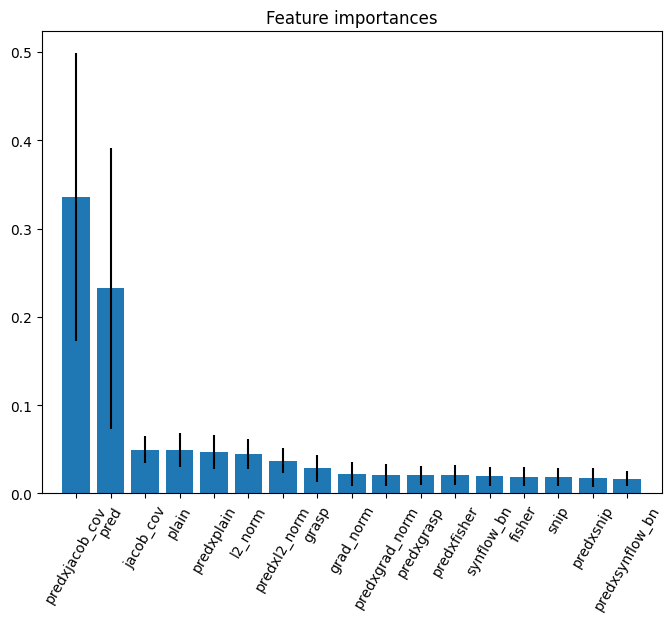

: 

In [149]:
# Obtain feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
labels = [X_train.columns[i] for i in indices]
# Plot the feature importances
plt.figure(figsize=(8,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), labels, rotation=60)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [101]:
[X_train.columns[i] for i in indices]

['pred',
 'plain',
 'l2_norm',
 'jacob_cov',
 'grasp',
 'fisher',
 'grad_norm',
 'snip',
 'synflow_bn']

In [104]:
train_df.to_csv("train_nas101_4k_medium.csv")
val_df.to_csv("val_nas101_4k_medium.csv")
test_df.to_csv("test_nas101_4k_medium.csv")

In [24]:
metrics = ['plain', 'snip', 'grasp', 'fisher', 'synflow', 'synflow_bn',
       'grad_norm', 'l2_norm', 'jacob_cov']
for metric in metrics:
    train_df[f"predx{metric}"] = train_df["pred"] * train_df[metric]
#     val_df[f"predx{metric}"] = val_df["pred"] * val_df[metric]
#     test_df[f"predx{metric}"] = test_df["pred"] * test_df[metric]

In [112]:
train_df.columns

Index(['plain', 'snip', 'grasp', 'fisher', 'synflow', 'synflow_bn',
       'grad_norm', 'l2_norm', 'jacob_cov', 'hash', 'pred', 'target',
       'predxplain', 'predxsnip', 'predxgrasp', 'predxfisher', 'predxsynflow',
       'predxsynflow_bn', 'predxgrad_norm', 'predxl2_norm', 'predxjacob_cov'],
      dtype='object')

In [29]:
from nas_201_api import NASBench201API as API


In [31]:
api = API('/home/ec2-user/nas-rec-engine/NAS-Bench-201-v1_1-096897.pth')

try to create the NAS-Bench-201 api from /home/ec2-user/nas-rec-engine/NAS-Bench-201-v1_1-096897.pth


In [15]:
from tqdm import tqdm
import pandas as pd

In [33]:
nas201_cf10_preds_df = pd.DataFrame({"pred": preds, "targets": targets, "hashes": hashes})

In [34]:
nas201_cf10_preds_df.to_csv("nas201_cf10_preds_df.csv")

In [20]:
nas201_imgnet = pd.read_csv('nas201_imgnet.csv')
nas201_cf10 = pd.read_csv('nas201_cf10.csv')
nas201_cf100 = pd.read_csv('nas201_cf100.csv')

In [44]:
test_df = pd.merge(nas201_cf10_preds_df, nas201_imgnet, left_on="hashes", right_on="idx").fillna(1.0)
#test_df["synflow"] = np.log10(test_df["synflow"])
X_test = test_df[['plain', 'snip', 'grasp', 'fisher', 'synflow_bn',
       'grad_norm', 'jacob_cov', 'pred']]
y_test = test_df["target"]
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate the performance of the random forest regressor
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

correlation, p_value = spearmanr(y_test, y_pred)

print("Spearman correlation coefficient:", correlation)
print("p-value:", p_value)


Mean Squared Error: 7.329506000583675e-05
R-squared: 0.9919020923691583
Spearman correlation coefficient: 0.9931073879831982
p-value: 0.0


In [45]:
# Evaluate the performance of the random forest regressor
y_pred = rf.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

correlation, p_value = spearmanr(y_train, y_pred)

print("Spearman correlation coefficient:", correlation)
print("p-value:", p_value)

Mean Squared Error: 0.44891729312613016
R-squared: -96.74347591261517
Spearman correlation coefficient: 0.20736250874897716
p-value: 8.875064057663253e-308


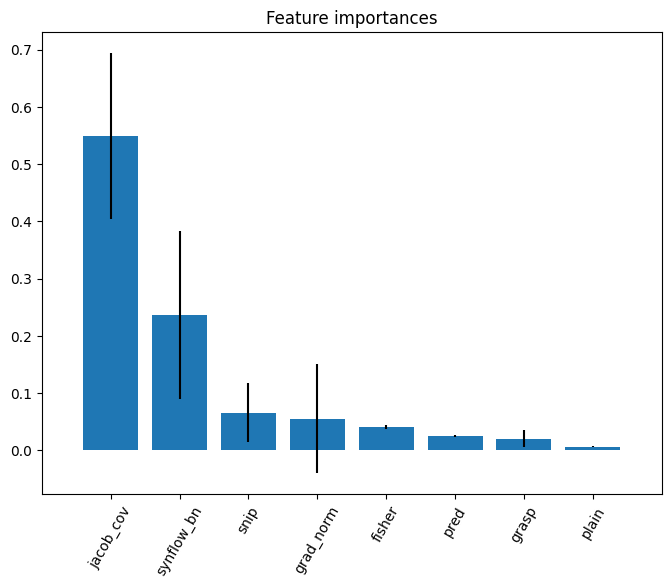

In [48]:
import matplotlib.pyplot as plt
# Obtain feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
labels = [X_train.columns[i] for i in indices]
# Plot the feature importances
plt.figure(figsize=(8,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), labels, rotation=60)
plt.xlim([-1, X_train.shape[1]])
plt.show()